# Python Financial Project

In [ ]:
'''
CONTEXT

A CLIENT CALLS AND ASKS US WHAT ARE THE RETURNS OF HIS PORTFOLIO FROM THE START OF THE YEAR TILL TODAY, 
HE ASKS IF WE COULD SEND HIM A PDF AND EXCEL FILE TO HIS EMAIL ACCOUNT

TICKERS = ABEV: Ambev ; PLYA: Playa Hotels and Resorts; SU: SUNCOR; BKR: Baker Hughes
'''

In [1]:
#Import different modules we are utilizing for this project 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import getpass
import smtplib
from pandas_datareader import data as wb
import matplotlib.ticker as mtick

import dataframe_image as dfi

import io

from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch


In [2]:
#Clients informations stored in Dictionaries

tickers = {'Client 1':['AAPL', 'TSLA', 'XOM'] ,'Client 2': ['ABEV', 'PLYA', 'SU', 'BKR'], 'Client 3':['PG','GS', 'JPM']}

weights = {'Client 1': [0.25,0.25,0.5], 'Client 2':[0.25,0.25,0.25,0.25], 'Client 3': [0.3,0.3,0.4]}

In [3]:
#####NEED TO ACCOMPLISH####

#1. CREATE DATAFRAM FROM INDIV returns ////

#2. CREATE PDF
    #PORTFOLIO TOTAL RETURN
    #DATAFRAM INDIV RETURNS
    #GRAPH RETURNS
    

#3. SEND PDF MAIL TO CLIENT


In [11]:
class Client:
    
    def __init__(self,name):
        self.name = name
        self.tickers = tickers[name]
        self.weights = weights[name]
        
    def __str__(self):
        
        a = ''
        for ticker in range(len(self.tickers)):
            a += '\n'+self.tickers[ticker]
            
        return self.name+' has the folowing stocks: '+a
    
    
    def search_data(self):
        
        client_data = pd.DataFrame()
        
        for i in self.tickers:
            client_data[i] = wb.DataReader(i , data_source= 'yahoo', start = '2021-1-1')['Adj Close'] 
            
        return client_data
    
    
    def portfolio_returns_graph(self):
        
        client_data = self.search_data()
        
        normalized_data = (client_data/client_data.iloc[0] * 100) - 1

        normplot = normalized_data.plot(figsize=(15,6))
        normplot.set_title('Normarlized returns from 2021-1-1')
        normplot.set_xlabel('Time Frame')
        normplot.set_ylabel('Normalized returns')
        normplot.yaxis.set_major_formatter(mtick.PercentFormatter())
        normplot.yaxis.grid(True)
        normplot.xaxis.grid(True)

        plt.savefig("output.png", dpi=300)
        
        
        return plt.show()
    
    
    def individual_avg_returns(self):
        
        client_data = self.search_data()
        
        returns = (client_data/client_data.shift(1))-1 

        average_returns = (returns.mean() * 250) #We utilize 250 trading days
        
        return average_returns
        
    
    def table_indiv_returns(self):
        
        
        average_returns = round(self.individual_avg_returns(),4)*100
        
        indiv_datafram = pd.DataFrame(average_returns)
        
        new_data = indiv_datafram.set_axis(['Returns (%)'], axis=1)
        
        return new_data
        
        
    def portfolio_avg_returns(self):
        
        average_returns = self.individual_avg_returns()
        
        calc_returns = np.dot(average_returns, self.weights)

        returns_portfolio = str(round(calc_returns,4)*100) + '%'
        
        print('Return of Portfolio:',returns_portfolio)
        
    
    def create_report(self, style="Normal", fontsize=12):
    
        def save_image_graph():

            client_data = self.search_data()
        
            normalized_data = (client_data/client_data.iloc[0] * 100) - 1

            normplot = normalized_data.plot(figsize=(15,6))
            normplot.set_title('Normarlized returns from 2021-1-1')
            normplot.set_xlabel('Time Frame')
            normplot.set_ylabel('Normalized returns')
            normplot.yaxis.set_major_formatter(mtick.PercentFormatter())
            normplot.yaxis.grid(True)
            normplot.xaxis.grid(True)

            # create buffer and save image to buffer
            # dpi should match the dpi of your PDF, I think 300 is typical otherwise it won't pretty well
            
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=300)
            
            buf.seek(0)
            # you'll want to close the figure once its saved to buffer
            

            plt.close()

            return buf
        
        
        
        def save_image_dataframe():
            
            return dfi.export(self.table_indiv_returns(),"table.png")
        
        
        def add_text(text, style="Normal", fontsize=12):
            """ Adds text with some spacing around it to  PDF report 

            Parameters
            ----------
            text : str
                The string to print to PDF

            style : str
                The reportlab style

            fontsize : int
                The fontsize for the text
            """
            Story.append(Spacer(1, 12))
            ptext = "<font size={}>{}</font>".format(fontsize, text)
            Story.append(Paragraph(ptext, styles[style]))
            Story.append(Spacer(1, 12))

        
        def str_portfolio_returns():
            
            average_returns = self.individual_avg_returns()
        
            calc_returns = np.dot(average_returns, self.weights)

            returns_portfolio = str(round(calc_returns,4)*100) + '%'

            return returns_portfolio
        
        
        
        
        # Use basic styles and the SimpleDocTemplate to get started with reportlab
        styles=getSampleStyleSheet()
        doc = SimpleDocTemplate(f"{self.name}-year performance.pdf",pagesize=letter,
                                rightMargin=inch/2,leftMargin=inch/2,
                                topMargin=72,bottomMargin=18)

        # The "story" just holds "instructions" on how to build the PDF
        
        p_return = str_portfolio_returns()
        
        Story=[]

        add_text("Year Peformance Report", style="Heading1", fontsize=24)

        
        add_text(f"Your total portfolio return is: \n{p_return}")
        
        
        # See plot_hist for information on how to get BytesIO object of matplotlib plot
        # This code uses reportlab Image function to add and valid PIL input to the report
        
        image_buffer1 = save_image_graph()
        im = Image(image_buffer1, 8.5*inch, 3*inch)
        Story.append(im)

        add_text("This chart shows the returns of each individual stock of your portfolio.")

        add_text("\n")
        
        save_image_dataframe()
        
        im = Image('/YOUR PATH/Financial Proyects/table.png', 1.75*inch, 1.75*inch)
        Story.append(im)

        add_text("\n")
        
        add_text("This table shows the returns of each individual stock of your portfolio.")
        
        
        #add_text("This text explains something else about another chart chart.")

        # This command will actually build the PDF
        doc.build(Story)

        # should close open buffers, can use a "with" statement in python to do this for you
        # if that works better
        image_buffer1.close()
        #image_buffer2.close()
        
        print(f'Report for {self.name} created succesfully!')
        


In [12]:
client_2 = Client('Client 2')

In [13]:
client_2.table_indiv_returns()

,Returns (%)
ABEV,10.20
PLYA,63.88
SU,67.14
BKR,34.53


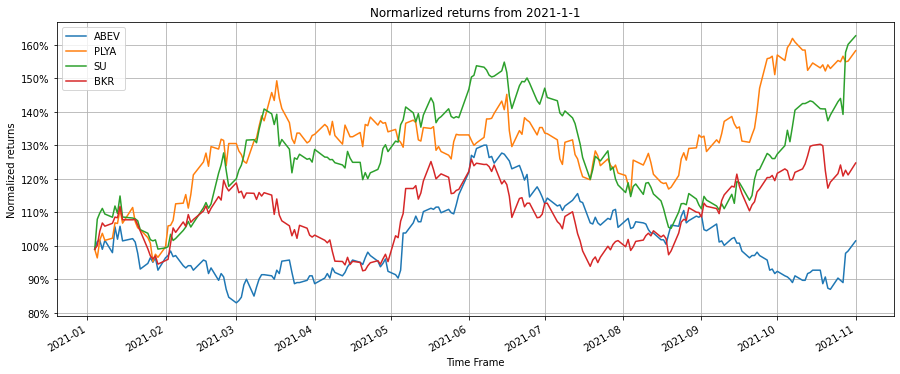

In [14]:
client_2.portfolio_returns_graph()

In [15]:
client_2.create_report()

Report for Client 2 created succesfully!


In [9]:
client_1 = Client('Client 1')

In [10]:
client_1.create_report()